In [276]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from utils import *
sns.set()

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import datetime as dt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import scipy

In [277]:
import warnings
warnings.filterwarnings("ignore")

In [278]:
testdf = pd.read_csv('./Data/test_1eLl9Yf.csv')

In [279]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [280]:
df_1,df_2,testdf = read_data()

ts1,mindate1,maxdate1=format_ts(df_1,'case_count',make_test_pred=1)
ts2,mindate2,maxdate2=format_ts(df_2,'case_count',make_test_pred=1)

Time period given:  2017-04-01 00:00:00 2019-07-05 00:00:00
Time period used for training:  2017-04-01 2019-07-05
Time period given:  2017-04-01 00:00:00 2019-07-23 00:00:00
Time period used for training:  2017-04-01 2019-07-23


In [281]:
sensex_df = pd.read_csv('Data/SENSEX.csv') # BSE index
sensex_df.columns = ['application_date','Open','High','Low','Close']
sensex_df = sensex_df[['application_date','Open','High','Low','Close']]
sensex_df['application_date'] = sensex_df['application_date'].apply(lambda x: dt.datetime.strptime(x,'%d-%B-%Y'))
sensex_df.head()

,application_date,Open,High,Low,Close
0,2017-01-02,26711.15,26720.98,26447.06,26595.45
1,2017-01-03,26616.92,26724.40,26488.37,26643.24
2,2017-01-04,26677.22,26723.37,26606.06,26633.13
3,2017-01-05,26738.42,26917.21,26738.42,26878.24
4,2017-01-06,26929.69,27009.61,26733.33,26759.23


In [282]:
sint = pd.read_csv('Data/DP_LIVE_25012020081817173.csv')[['TIME','Value']] # Short term interest rates
sint.index = pd.to_datetime(sint['TIME'], format='%Y-%m')
sint.drop('TIME',axis=1,inplace=True)
sint=sint.resample('D').ffill().reset_index()
sint.columns = ['application_date','sint']
sint.head()

,application_date,sint
0,2017-01-01,6.24
1,2017-01-02,6.24
2,2017-01-03,6.24
3,2017-01-04,6.24
4,2017-01-05,6.24


In [283]:
lint = pd.read_csv('Data/DP_LIVE_25012020081930081.csv')[['DATE','LINT']] # Long term interest rates
lint.index = pd.to_datetime(lint['DATE'], format='%Y-%m')
lint.drop('DATE',axis=1,inplace=True)
lint=lint.resample('D').ffill().reset_index()
lint.columns = ['application_date','lint']
lint.head()

,application_date,lint
0,2017-01-01,6.7925
1,2017-01-02,6.7925
2,2017-01-03,6.7925
3,2017-01-04,6.7925
4,2017-01-05,6.7925


In [284]:
cpi = pd.read_csv('Data/DP_LIVE_25012020082029409.csv')[['DATE','CPI']] # Consumer Price Index
cpi.index = pd.to_datetime(cpi['DATE'], format='%Y-%m')
cpi.drop('DATE',axis=1,inplace=True)
cpi=cpi.resample('D').ffill().reset_index()
cpi.columns = ['application_date','cpi']
cpi.head()

,application_date,cpi
0,2017-01-01,1.858736
1,2017-01-02,1.858736
2,2017-01-03,1.858736
3,2017-01-04,1.858736
4,2017-01-05,1.858736


In [285]:
from functools import reduce

econdata = reduce(lambda x,y: x.merge(y,on='application_date',how='outer'),[sint,lint,cpi,sensex_df])

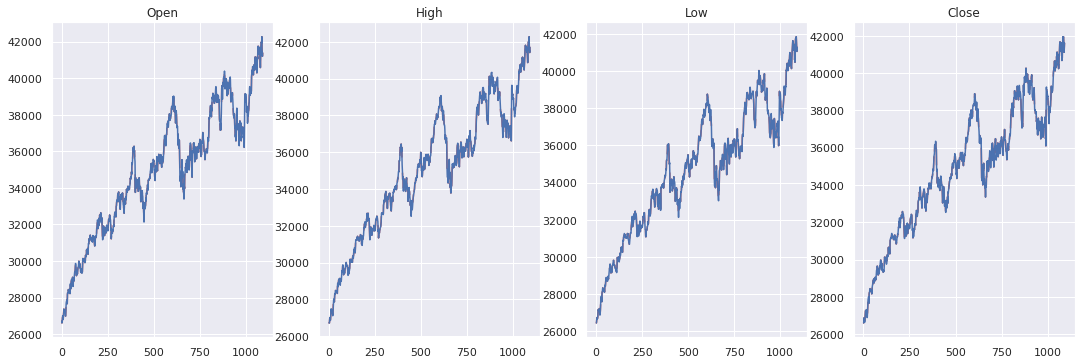

,application_date,sint,lint,cpi,Open,High,Low,Close,sensex_missing
0,2017-01-01,6.24,6.7925,1.858736,NaN,NaN,NaN,NaN,1
1,2017-01-02,6.24,6.7925,1.858736,26711.15,26720.98,26447.06,26595.45,0
2,2017-01-03,6.24,6.7925,1.858736,26616.92,26724.40,26488.37,26643.24,0
3,2017-01-04,6.24,6.7925,1.858736,26677.22,26723.37,26606.06,26633.13,0
4,2017-01-05,6.24,6.7925,1.858736,26738.42,26917.21,26738.42,26878.24,0


In [286]:
# Filling nans in sensex data
econdata['sensex_missing'] = 0
econdata['sensex_missing'][econdata.isna().sum(1)>0]=1

fig,ax=plt.subplots(1,4,figsize=(15, 5))
fig.tight_layout()    
i=0
for col in ['Open','High','Low','Close']: 
    ax[i].plot(econdata.index, econdata[col], color='r')
    splined=econdata[col].interpolate(method='polynomial',order=3)
    ax[i].plot(econdata.index, splined, color='b')
    ax[i].title.set_text(col)
    econdata[col]=econdata[col].interpolate(method='polynomial',order=3)
    i+=1
plt.show()   
econdata.head()

In [287]:
print(econdata.dropna().shape)
print(econdata.shape)
econdata.index = econdata['application_date']
econdata.drop('application_date',1,inplace=True)

(1034, 9)
(1093, 9)


In [288]:
ts_1 = ts1.join(econdata)
ts_2 = ts2.join(econdata)
ts_1.head()

,y,sint,lint,cpi,Open,High,Low,Close,sensex_missing
ds,,,,,,,,,
2017-04-01,299.0,6.035,7.165,2.214022,29671.611403,29728.470922,29590.808607,29666.466824,1
2017-04-02,0.0,6.035,7.165,2.214022,29678.952801,29823.703125,29644.708201,29790.352067,1
2017-04-03,42.0,6.035,7.165,2.214022,29737.730000,29926.940000,29705.720000,29910.220000,0
2017-04-04,23.0,6.035,7.165,2.214022,29887.145677,29996.239773,29765.625834,29964.644764,1
2017-04-05,1530.0,6.035,7.165,2.214022,29996.030000,30007.480000,29817.690000,29974.240000,0


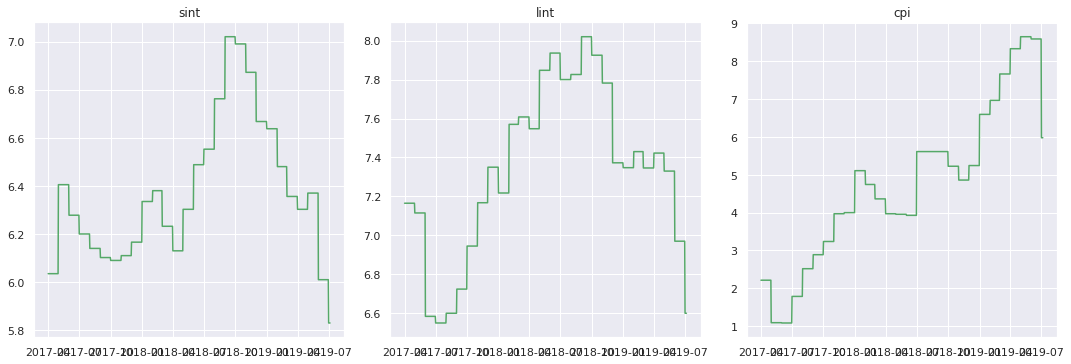

In [289]:
# Plotting interest rates and cpi

fig,ax=plt.subplots(1,3,figsize=(15, 5))
fig.tight_layout()    
i=0
for col in ['sint','lint','cpi']: 
    ax[i].plot(ts_1.index, ts_1[col], color='g')
    ax[i].title.set_text(col)
    i+=1
plt.show()   

In [290]:
ts_1.isna().sum()

y                 0
sint              0
lint              0
cpi               0
Open              0
High              0
Low               0
Close             0
sensex_missing    0
dtype: int64

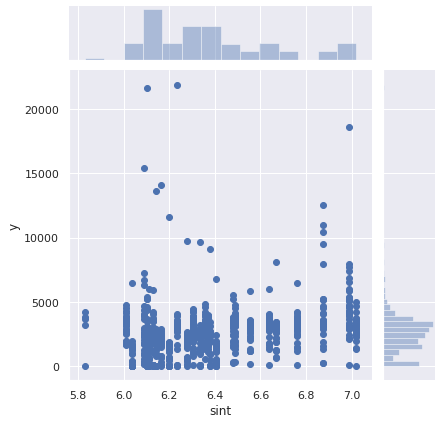

In [291]:
# Correlation between short term interest rates and form submissions
sns.jointplot(x='sint', y='y', data=ts_1)  
plt.show()

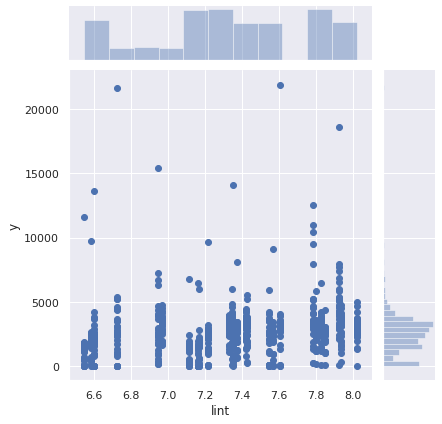

In [292]:
# Correlation between long term interest rates and form submissions
sns.jointplot(x='lint', y='y', data=ts_1)  
plt.show()

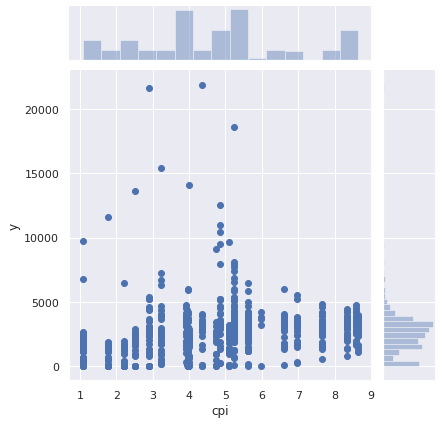

In [293]:
# Correlation between cpi rates and form submissions
sns.jointplot(x='cpi', y='y', data=ts_1)  
plt.show()

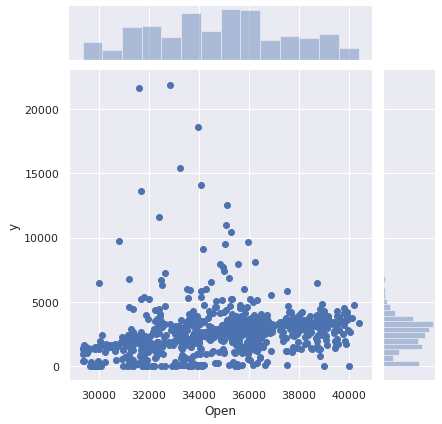

In [294]:
# Correlation between Opening sensex and form submissions
sns.jointplot(x='Open', y='y', data=ts_1)  
plt.show()

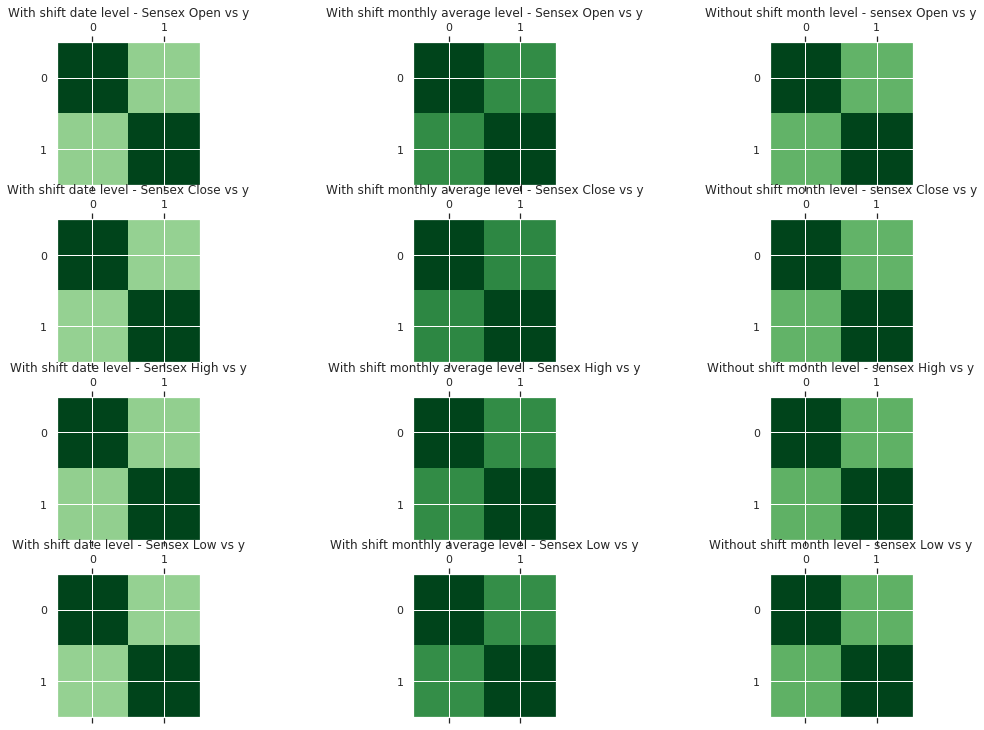

In [295]:
#Correlations b/w Application submissions and stock price movements

fig,ax=plt.subplots(4,3,figsize=(15, 10))
fig.tight_layout()    
i=0
for i,col in enumerate(['Open','Close','High','Low']):
    j=0
    ax[i,j].matshow(pd.concat([ts_1['y'],ts_1[col].shift(1)],axis=1).corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    ax[i,j].title.set_text('With shift date level - Sensex '+col+' vs y')
    j+=1
    
    monthly = ts_1.resample('M').mean()[['y',col]]
    ax[i,j].matshow(pd.concat([monthly['y'],monthly[col].shift(2)],axis=1).corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    ax[i,j].title.set_text('With shift monthly average level - Sensex '+col+' vs y')
    j+=1

    # Correlation without shift at monthly average level
    ax[i,j].matshow(monthly.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    ax[i,j].title.set_text('Without shift month level - sensex '+col+' vs y')
    i+=1
plt.show()    

## Corrlplot with shift of 2 months at monthly average level has highest correlation

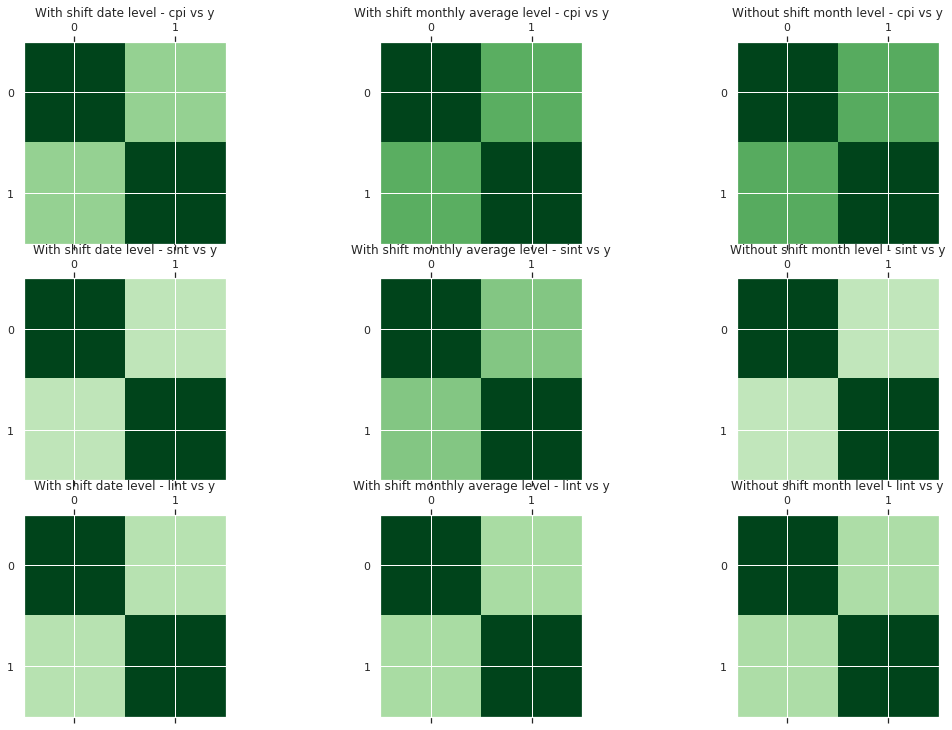

In [296]:
#Correlations b/w Application submissions and CPI and interest rate movements

fig,ax=plt.subplots(3,3,figsize=(15, 10))
fig.tight_layout()    
i=0
for i,col in enumerate(['cpi','sint','lint']):
    j=0
    ax[i,j].matshow(pd.concat([ts_1['y'],ts_1[col].shift(1)],axis=1).corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    ax[i,j].title.set_text('With shift date level - '+col+' vs y')
    j+=1
    
    monthly = ts_1.resample('M').mean()[['y',col]]
    ax[i,j].matshow(pd.concat([monthly['y'],monthly[col].shift(2)],axis=1).corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    ax[i,j].title.set_text('With shift monthly average level - '+col+' vs y')
    j+=1

    # Correlation without shift at monthly average level
    ax[i,j].matshow(monthly.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    ax[i,j].title.set_text('Without shift month level - '+col+' vs y')
    i+=1
plt.show()    

## 2 month shift in monthly average is significant for short term interest rates

In [297]:
# Shifting cpi, lint, sint, sensex indicators by 2 months
shifted_econ=econdata.resample('M').mean().shift(2).resample('D').ffill()
ts_1 = ts1.join(shifted_econ)
ts_2 = ts2.join(shifted_econ)
ts_1.head()

,y,sint,lint,cpi,Open,High,Low,Close,sensex_missing
ds,,,,,,,,,
2017-04-01,299.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581
2017-04-02,0.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581
2017-04-03,42.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581
2017-04-04,23.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581
2017-04-05,1530.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581


## Application distribution among locations

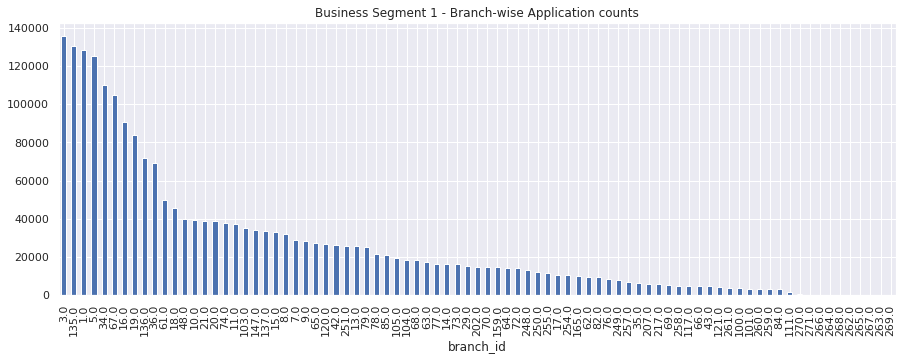

In [298]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
branchcounts=df_1.groupby('branch_id')['case_count'].sum().sort_values(ascending=False)
branchcounts.plot(kind='bar')
plt.title('Business Segment 1 - Branch-wise Application counts')
plt.show()

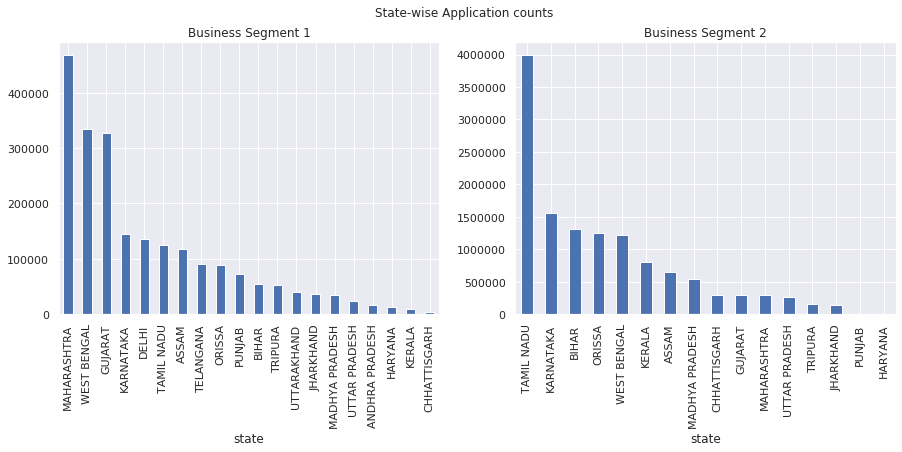

In [299]:
# State wise counts

fig,ax=plt.subplots(1,2,figsize=(15,5))
branchcounts=df_1.groupby('state')['case_count'].sum().sort_values(ascending=False)
branchcounts.plot(kind='bar', orientation='vertical', ax=ax[0])
ax[0].title.set_text('Business Segment 1')
branchcounts=df_2.groupby('state')['case_count'].sum().sort_values(ascending=False)
branchcounts.plot(kind='bar', orientation='vertical', ax=ax[1])
ax[1].title.set_text('Business Segment 2')
fig.suptitle('State-wise Application counts')                     
plt.show()

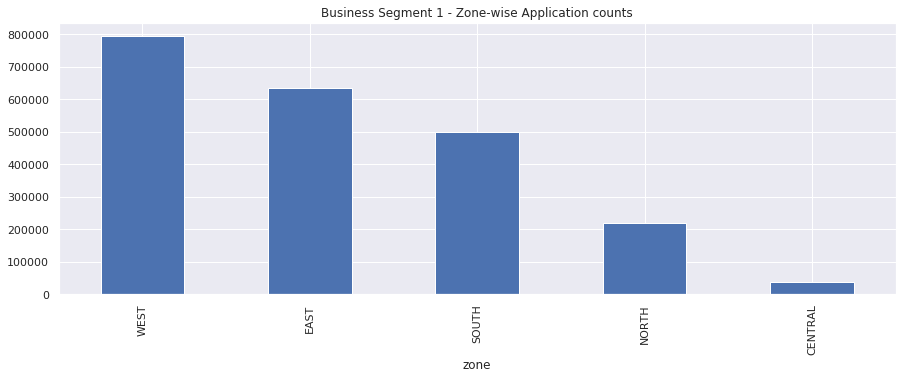

In [300]:
# Zone wise counts

plt.figure(figsize=(15,5))
branchcounts=df_1.groupby('zone')['case_count'].sum().sort_values(ascending=False)
branchcounts.plot(kind='bar')
plt.title('Business Segment 1 - Zone-wise Application counts')
plt.show()

In [301]:
branchcounts

zone
WEST       795269.0
EAST       634815.0
SOUTH      500040.0
NORTH      220707.0
CENTRAL     37209.0
Name: case_count, dtype: float64

## Preparing final data

In [302]:
# Segment 1 data preparation

import glob
from functools import reduce

dfs=[]
for f in glob.iglob('./Data/segment1*.csv'):
    file=pd.read_csv(f)
    dfs.append(file)
    
geodata1 = reduce(lambda x,y: x.merge(y,on='time',how='inner'),dfs)
geodata1.columns = ['ds']+list(geodata1.columns)[1:]
geodata1.index=geodata1['ds']
geodata1=geodata1.drop('ds',axis=1)

dat1 = ts_1.join(geodata1)
dat1.head()    

,y,sint,lint,cpi,Open,High,Low,Close,sensex_missing,1.0_perc,...,GUJARAT_perc,ASSAM_perc,JHARKHAND_perc,UTTARAKHAND_perc,KERALA_perc,CHHATTISGARH_perc,BIHAR_perc,TRIPURA_perc,MADHYA PRADESH_perc,HARYANA_perc
ds,,,,,,,,,,,,,,,,,,,,,
2017-04-01,299.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,0.133779,...,0.046823,0.056856,0.033445,0.036789,0.000000,0.0,0.020067,0.006689,0.023411,0.0
2017-04-02,0.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-03,42.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,0.119048,...,0.000000,0.023810,0.000000,0.023810,0.000000,0.0,0.000000,0.000000,0.047619,0.0
2017-04-04,23.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,0.173913,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.043478,0.0
2017-04-05,1530.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,0.073856,...,0.156863,0.059477,0.009150,0.011765,0.007843,0.0,0.012418,0.013725,0.013725,0.0


In [303]:
# Segment 2 data preparation

for f in glob.iglob('./Data/segment2*.csv'):
    geodata2=pd.read_csv(f)
geodata2.columns = ['ds']+list(geodata2.columns)[1:]
geodata2.index=geodata2['ds']
geodata2=geodata2.drop('ds',axis=1)
dat2 = ts_2.join(geodata2)
dat2.head()    

,y,sint,lint,cpi,Open,High,Low,Close,sensex_missing,ASSAM_perc,...,KERALA_perc,KARNATAKA_perc,MAHARASHTRA_perc,MADHYA PRADESH_perc,ORISSA_perc,PUNJAB_perc,TAMIL NADU_perc,TRIPURA_perc,UTTAR PRADESH_perc,WEST BENGAL_perc
ds,,,,,,,,,,,,,,,,,,,,,
2017-04-01,897.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,0.0,...,0.025641,0.183946,0.0,0.040134,0.123746,0.0,0.510591,0.0,0.030100,0.047938
2017-04-02,605.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,0.0,...,0.009917,0.147107,0.0,0.000000,0.244628,0.0,0.300826,0.0,0.036364,0.191736
2017-04-03,2016.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,0.0,...,0.075397,0.100694,0.0,0.013889,0.115575,0.0,0.575893,0.0,0.003472,0.088294
2017-04-04,2245.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,0.0,...,0.065033,0.177283,0.0,0.037862,0.122940,0.0,0.392428,0.0,0.008909,0.143875
2017-04-05,2415.0,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,0.0,...,0.071636,0.103520,0.0,0.000000,0.093996,0.0,0.472878,0.0,0.016149,0.183437


In [304]:
dat1.isna().sum()

y                       0
sint                    0
lint                    0
cpi                     0
Open                    0
                       ..
CHHATTISGARH_perc      20
BIHAR_perc             20
TRIPURA_perc           20
MADHYA PRADESH_perc    20
HARYANA_perc           20
Length: 117, dtype: int64

In [305]:
dat2.isna().sum()

y                      0
sint                   0
lint                   0
cpi                    0
Open                   0
High                   0
Low                    0
Close                  0
sensex_missing         0
ASSAM_perc             0
BIHAR_perc             0
CHHATTISGARH_perc      0
GUJARAT_perc           0
HARYANA_perc           0
JHARKHAND_perc         0
KERALA_perc            0
KARNATAKA_perc         0
MAHARASHTRA_perc       0
MADHYA PRADESH_perc    0
ORISSA_perc            0
PUNJAB_perc            0
TAMIL NADU_perc        0
TRIPURA_perc           0
UTTAR PRADESH_perc     0
WEST BENGAL_perc       0
dtype: int64

In [306]:
dat1[dat1.isna().sum(1)>0]['y'].unique()

array([0.])

In [307]:
dat1=dat1.fillna(0)
dat2=dat2.fillna(0)

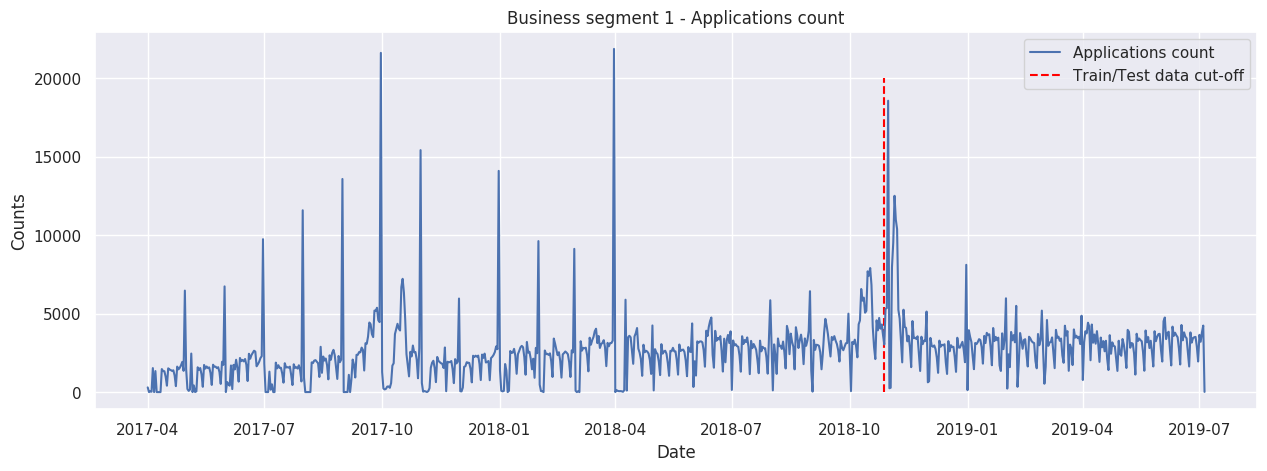

In [308]:
## Business Segment 1

plt.figure(figsize=(15, 5), dpi=100)
plt.plot(ts_1.index, ts_1.y, label='Applications count')
plt.vlines(ts_1.index.max()-dt.timedelta(days=250), 0, 20000, linestyles='--', colors='red', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.title('Business segment 1 - Applications count')
plt.legend()
plt.show()

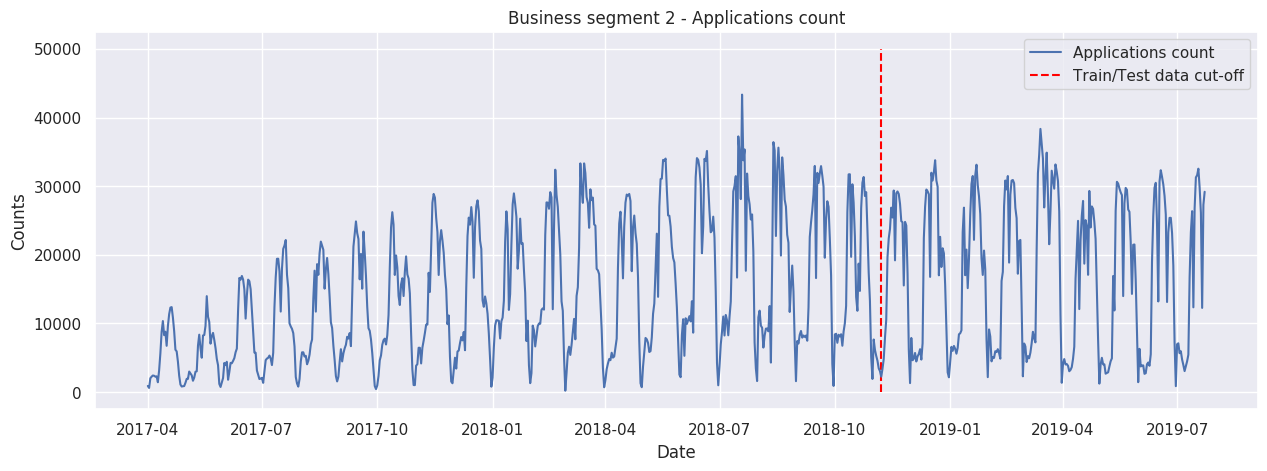

In [309]:
## Business Segment 2

plt.figure(figsize=(15, 5), dpi=100)
plt.plot(ts_2.index, ts_2.y, label='Applications count')
plt.vlines(ts_1.index.max()-dt.timedelta(days=240), 0, 50000, linestyles='--', colors='red', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.title('Business segment 2 - Applications count')
plt.legend()
plt.show()

In [310]:
# Removing prominent spikes from data before calculating technical indicators
'''
def despike(yi,th=1.e-8):
      #Remove spike from array yi, the spike area is where the difference between 
      #the neigboring points is higher than th.
      y = np.copy(yi) # use y = y1 if it is OK to modify input array
      n = len(y)
      x = np.arange(n)
      c = np.argmax(y)
      d = abs(np.diff(y))
      print(d[c-1::-1])
      try:
        l = c - 1 - np.where(d[c-1::-1]<th)[0][0]
        r = c + np.where(d[c:]<th)[0][0] + 1
      except: # no spike, return unaltered array
        print("no spike, return unaltered array")
        return y
      # for fit, use area twice wider then the spike
      if (r-l) <= 3:
        l -= 1
        r += 1
      s = int(round((r-l)/2.))
      lx = l - s
      rx = r + s
      # make a gap at spike area
      xgapped = np.concatenate((x[lx:l],x[r:rx]))
      ygapped = np.concatenate((y[lx:l],y[r:rx]))
      # quadratic fit of the gapped array
      z = np.polyfit(xgapped,ygapped,2)
      p = np.poly1d(z)
      y[l:r] = p(x[l:r])
      return y

spiked_arrs = [
              dat1.y[(dat1.index>'2018-02-18') & (dat1.index<'2018-03-18')],
              dat1.y[(dat1.index>'2018-10-24') & (dat1.index<'2018-11-14')],
              dat1.y[(dat1.index>'2018-01-21') & (dat1.index<'2018-02-21')],       
              dat1.y[(dat1.index>'2017-06-20') & (dat1.index<'2017-07-10')],    
              dat1.y[(dat1.index>'2018-10-27') & (dat1.index<'2018-11-17')],              
              dat1.y[(dat1.index>'2018-10-20') & (dat1.index<'2018-11-16')],              
              dat1.y[(dat1.index>'2017-07-10') & (dat1.index<'2017-08-10')],              
              dat1.y[(dat1.index>'2018-10-25') & (dat1.index<'2018-11-15')],            
              dat1.y[(dat1.index>'2017-08-10') & (dat1.index<'2017-09-10')],            
              dat1.y[(dat1.index>'2017-12-10') & (dat1.index<'2018-01-10')],         
              dat1.y[(dat1.index>'2017-10-10') & (dat1.index<'2017-11-10')],
              dat1.y[(dat1.index>'2018-10-10') & (dat1.index<'2018-11-10')],
              dat1.y[(dat1.index>'2017-09-10') & (dat1.index<'2017-10-10')],
              dat1.y[(dat1.index>'2018-03-02') & (dat1.index<'2018-04-10')], 
              ]

for spiked in spiked_arrs:
    s = spiked.copy()
    spiked=despike(s)
'''    

'\ndef despike(yi,th=1.e-8):\n      #Remove spike from array yi, the spike area is where the difference between \n      #the neigboring points is higher than th.\n      y = np.copy(yi) # use y = y1 if it is OK to modify input array\n      n = len(y)\n      x = np.arange(n)\n      c = np.argmax(y)\n      d = abs(np.diff(y))\n      print(d[c-1::-1])\n      try:\n        l = c - 1 - np.where(d[c-1::-1]<th)[0][0]\n        r = c + np.where(d[c:]<th)[0][0] + 1\n      except: # no spike, return unaltered array\n        print("no spike, return unaltered array")\n        return y\n      # for fit, use area twice wider then the spike\n      if (r-l) <= 3:\n        l -= 1\n        r += 1\n      s = int(round((r-l)/2.))\n      lx = l - s\n      rx = r + s\n      # make a gap at spike area\n      xgapped = np.concatenate((x[lx:l],x[r:rx]))\n      ygapped = np.concatenate((y[lx:l],y[r:rx]))\n      # quadratic fit of the gapped array\n      z = np.polyfit(xgapped,ygapped,2)\n      p = np.poly1d(z)\n 

In [311]:
# Breaking segment 1 into train and validation sets
dat1['ytrue']=dat1['y']
train1=dat1[dat1.index<(ts_1.index.max()-dt.timedelta(days=250))]
val1=dat1[dat1.index>=(ts_1.index.max()-dt.timedelta(days=250))]

In [312]:
# Breaking segment 2 into train and validation sets
dat2['ytrue']=dat2['y']
train2=dat2[dat2.index<(ts_2.index.max()-dt.timedelta(days=240))]
val2=dat2[dat2.index>=(ts_2.index.max()-dt.timedelta(days=240))]

In [313]:
# Despiking Segment 1 train with Savitzky-Golay-Filter

def despike(dat,datset):
    despiked_y=scipy.signal.savgol_filter(dat.y, window_length=7, polyorder=3, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
    despiked_y = np.where(despiked_y<0,0,despiked_y)
    plt.figure(figsize=(15, 5), dpi=100)
    plt.plot(dat.index, despiked_y, label='Applications count')
    plt.xlabel('Date')
    plt.ylabel('Counts')
    plt.title('Business segment '+datset[-1]+' - Applications count '+datset[:-1]+' data')
    plt.legend()
    plt.show()
    return despiked_y

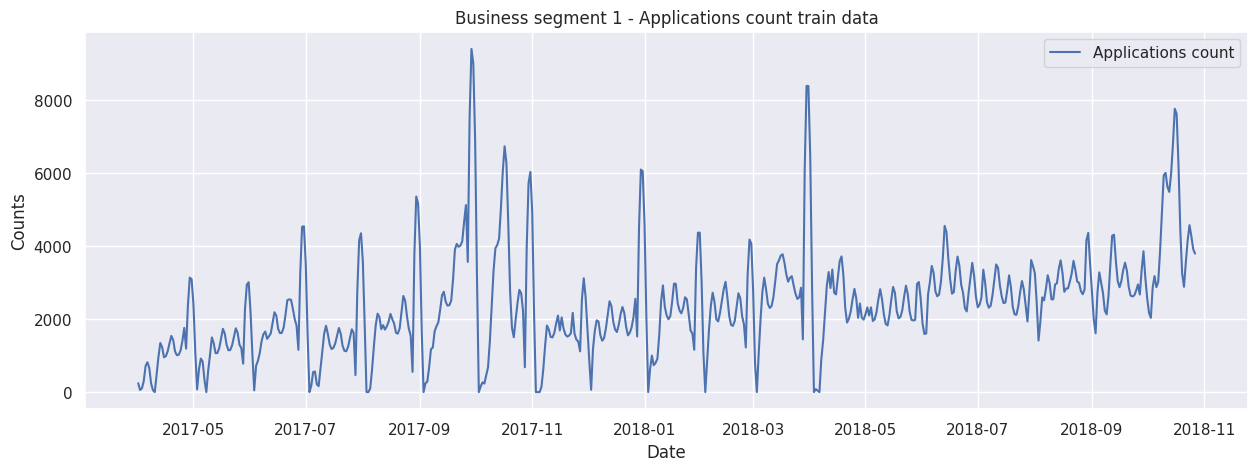

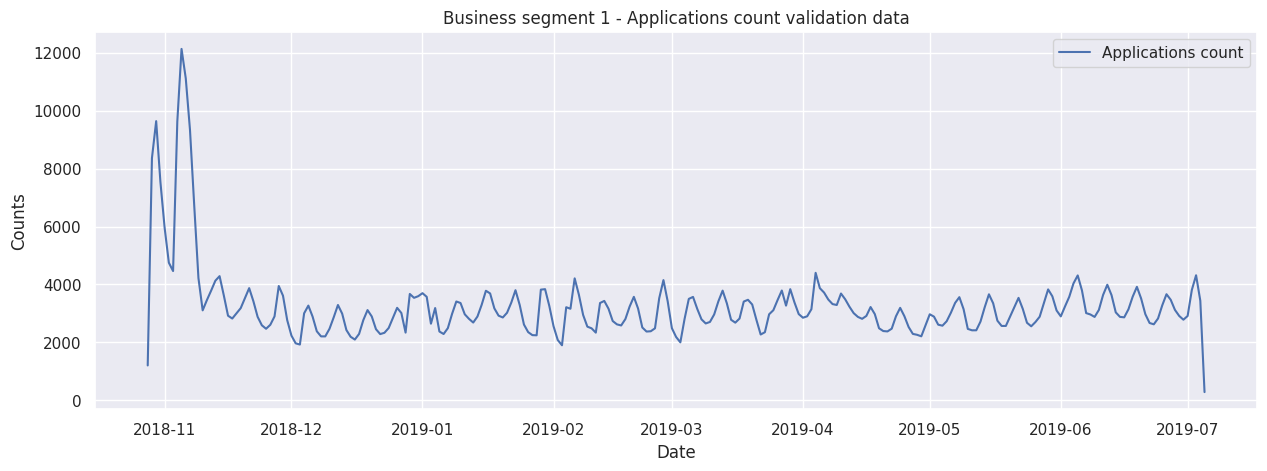

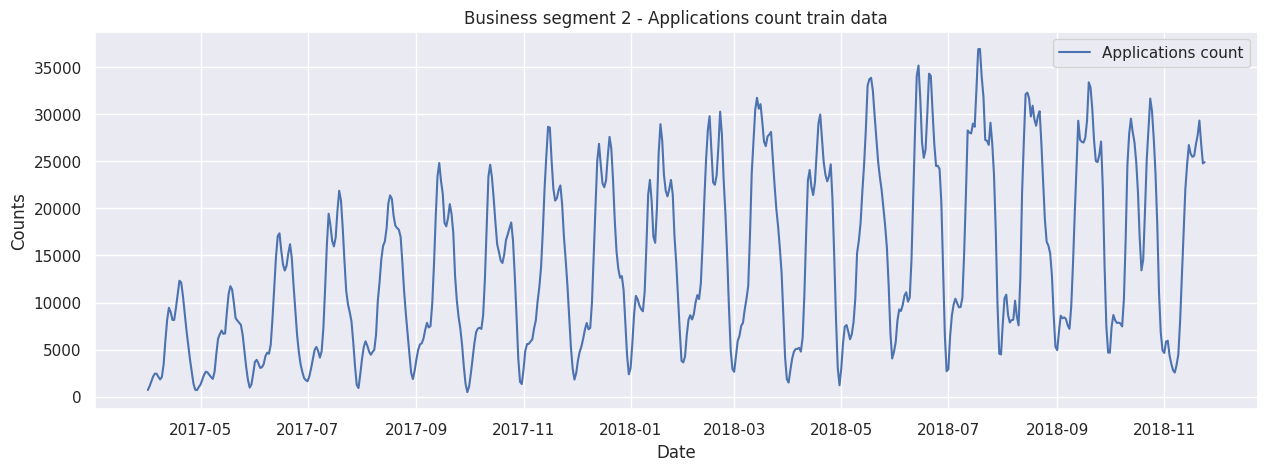

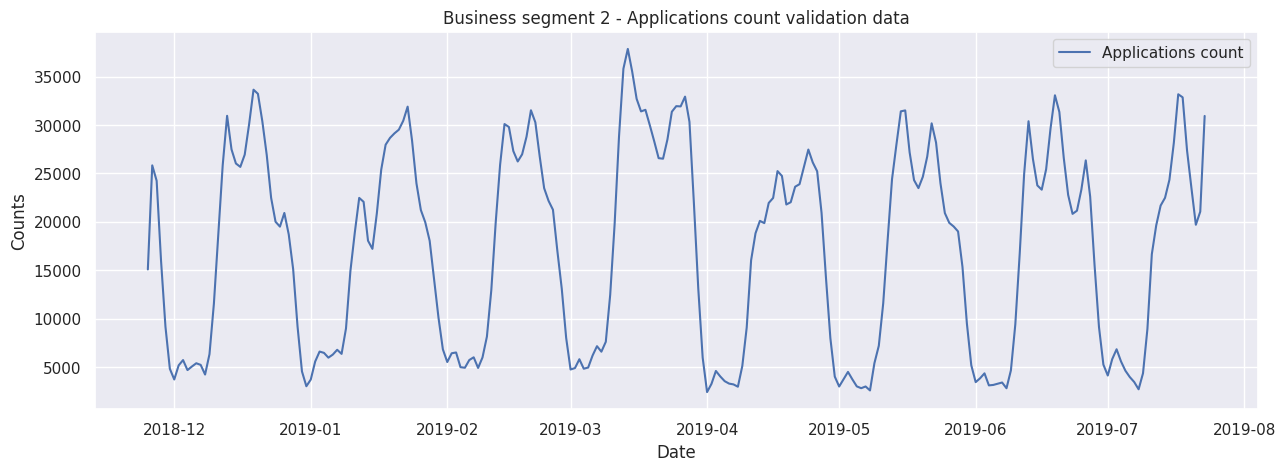

In [314]:
train1['y']=despike(train1,'train1')
val1['y']=despike(val1,'validation1')

train2['y']=despike(train2,'train2')
val2['y']=despike(val2,'validation2')

In [315]:
from ewma_calc import _ewma


def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['y'].rolling(window=7).mean()
    dataset['ma21'] = dataset['y'].rolling(window=21).mean()
    
    # Create MACD  
    dataset['26ema'] = _ewma(np.array(dataset['y']), 26) 
    dataset['12ema'] = _ewma(np.array(dataset['y']), 12)
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['y'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['y'].ewm(com=0.5).mean()
        
    return dataset

In [316]:
train1 = get_technical_indicators(train1)
val1 = get_technical_indicators(val1)

train2 = get_technical_indicators(train2)
val2 = get_technical_indicators(val2)

In [317]:
train1.isna().sum()

y              0
sint           0
lint           0
cpi            0
Open           0
              ..
MACD           0
20sd          19
upper_band    20
lower_band    20
ema            0
Length: 127, dtype: int64

In [318]:
train1 = train1.fillna(0)
val1 = val1.fillna(0)

train2 = train2.fillna(0)
val2 = val2.fillna(0)

In [319]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['y'],label='Count', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators - last {} days.'.format(last_days))
    plt.ylabel('Counts')
    plt.legend()
    

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    
    plt.legend()
    plt.show()

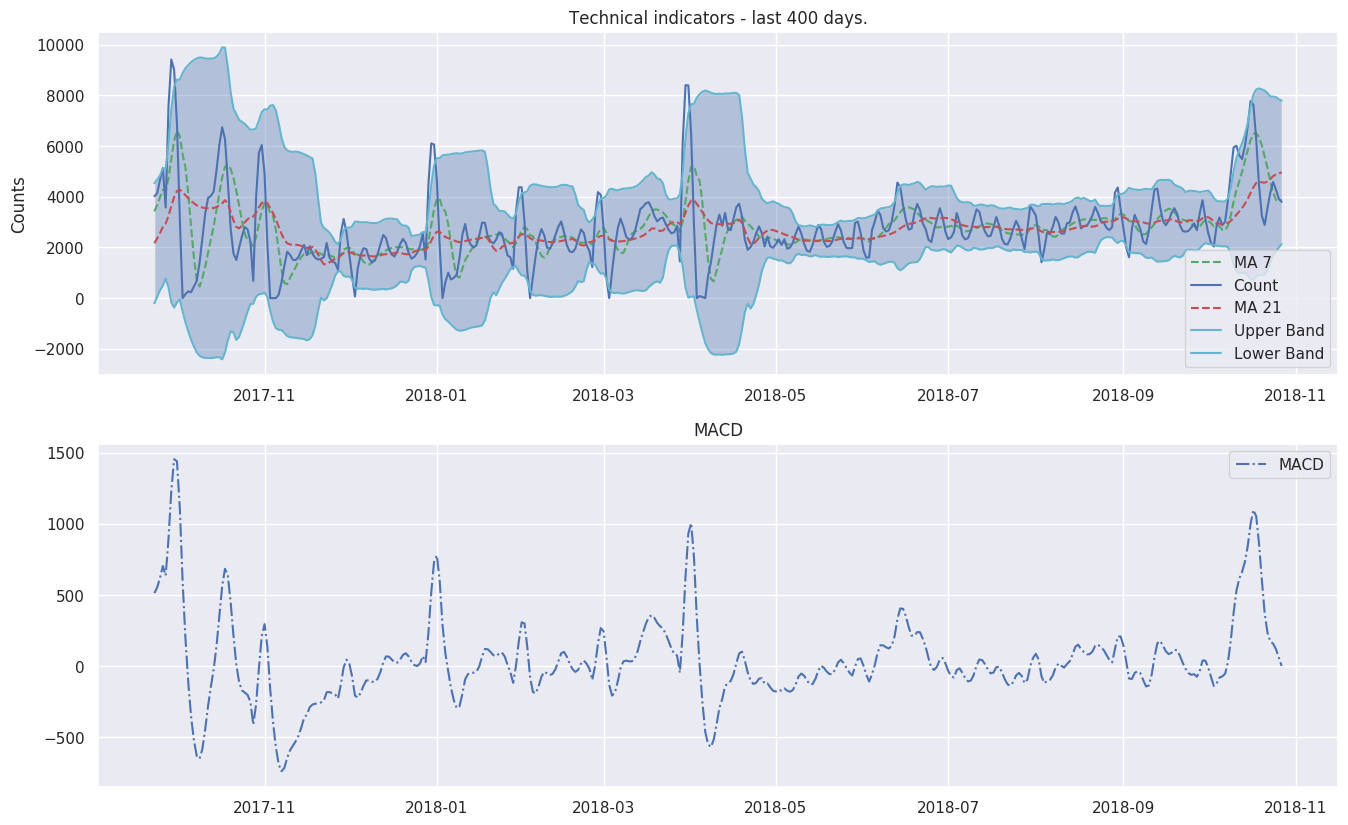

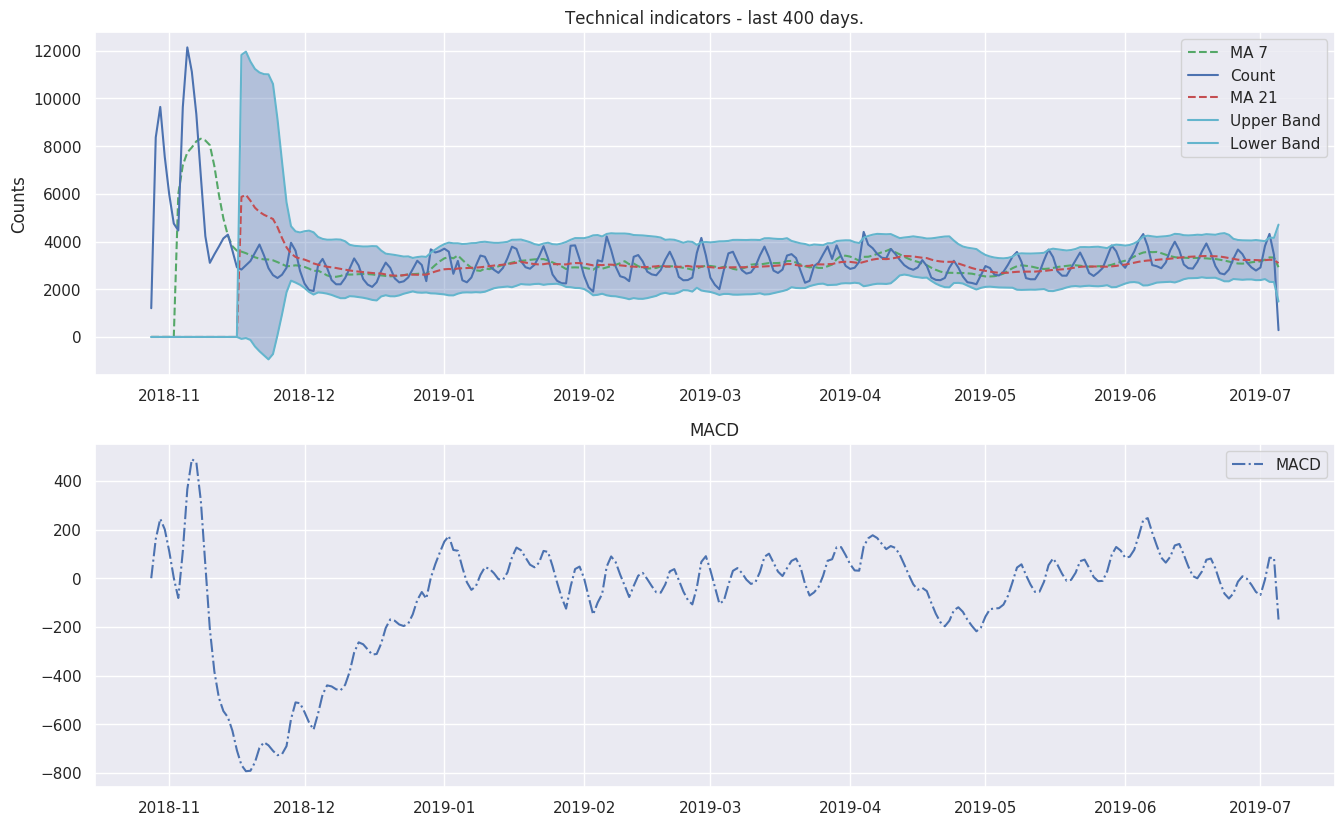

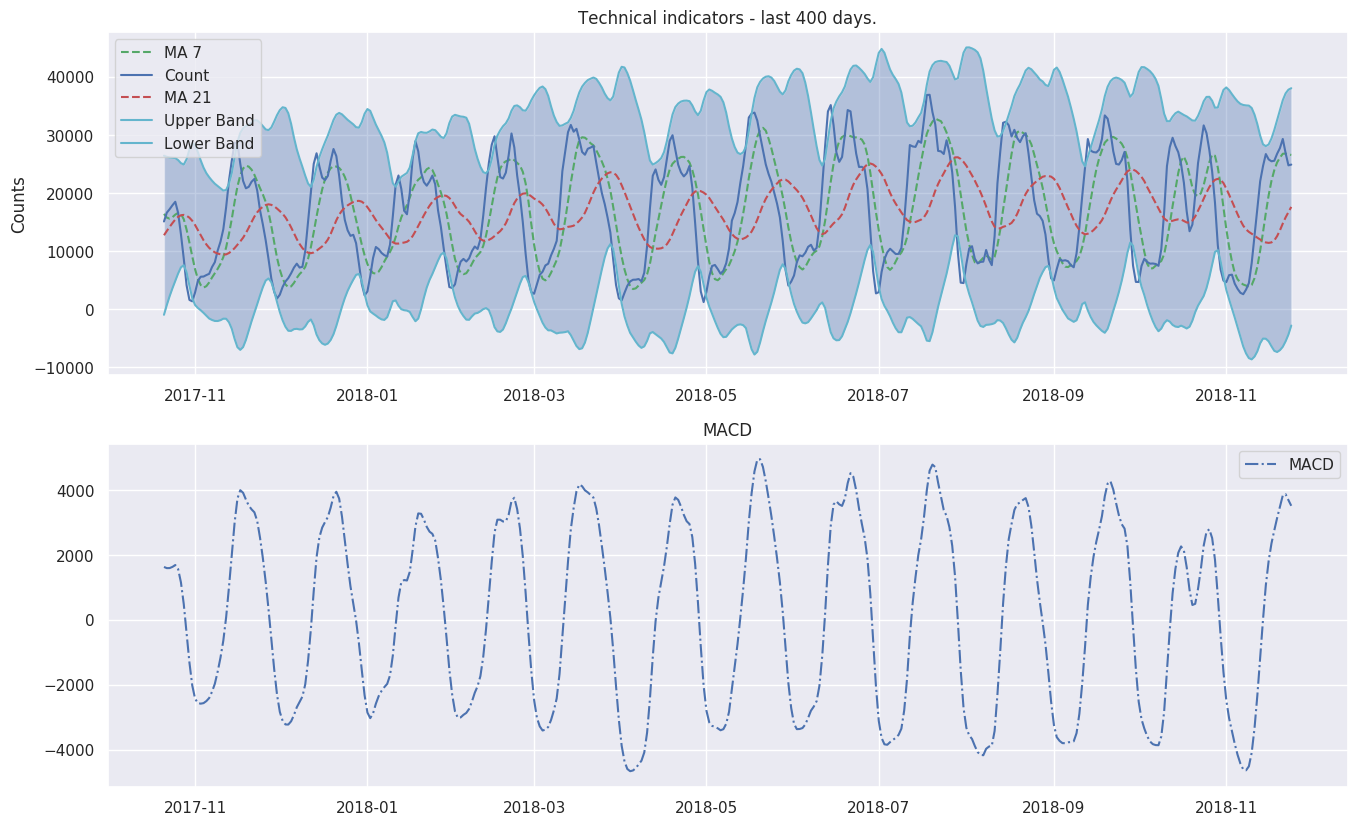

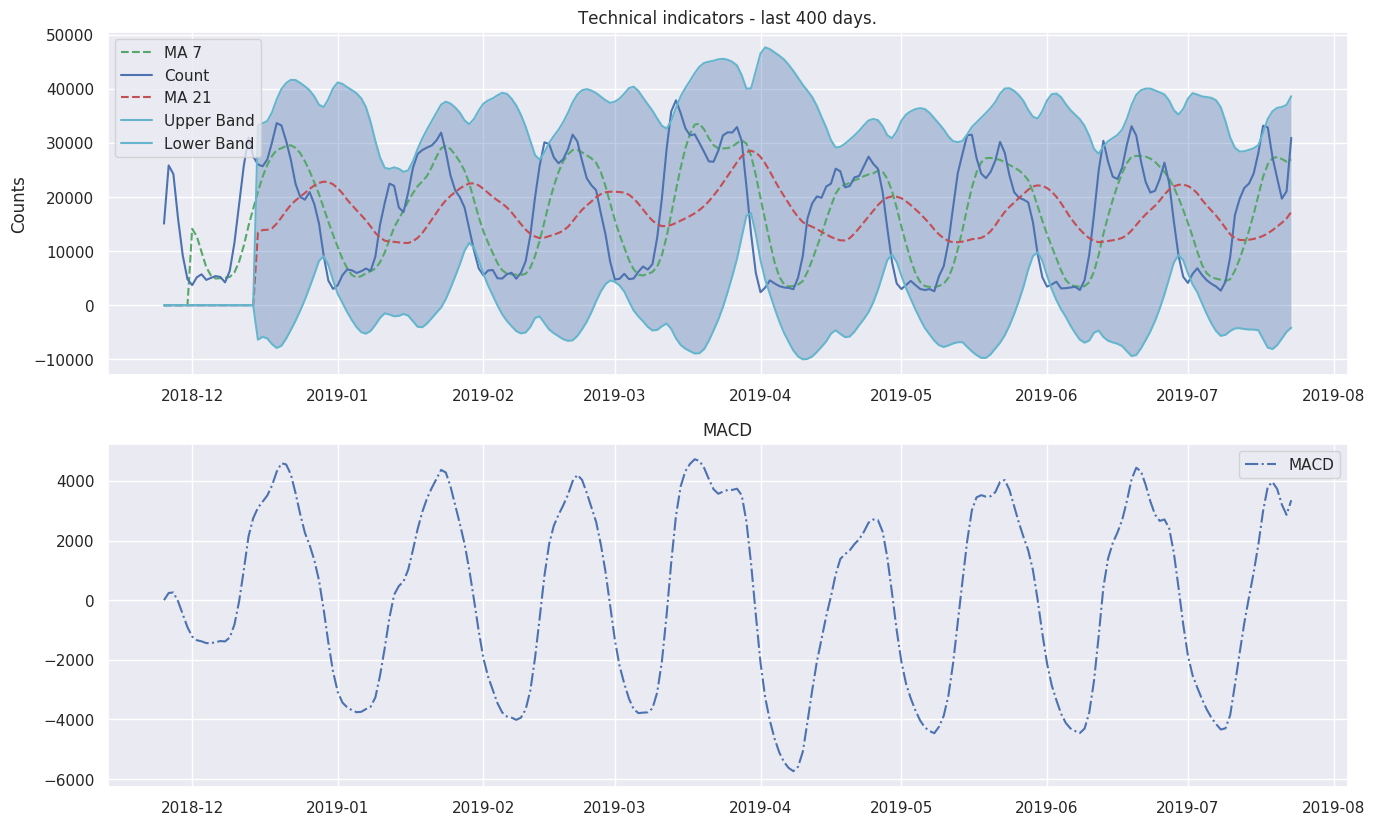

In [320]:
plot_technical_indicators(train1, 400)
plot_technical_indicators(val1, 400)

plot_technical_indicators(train2, 400)
plot_technical_indicators(val2, 400)

In [321]:
# Fourier components through fft
def fourier_components(dat):
    dat_ft = dat[['y']]
    close_fft1 = np.fft.fft(np.asarray(dat_ft['y'].tolist()))
    fft_df1 = pd.DataFrame({'fft':close_fft1})
    fft_df1['absolute'] = fft_df1['fft'].apply(lambda x: np.abs(x))
    fft_df1['angle'] = fft_df1['fft'].apply(lambda x: np.angle(x))

    plt.figure(figsize=(14, 7), dpi=100)
    fft_list1 = np.asarray(fft_df1['fft'].tolist())

    plt.plot(dat['y'].values, color='y', label='Actual')
    for num_ in [5, 15, 25, 50, 100]:
        fft_list1_m10= np.copy(fft_list1)
        fft_list1_m10[num_:-num_]=0
        plt.plot(np.fft.ifft(fft_list1_m10), label='Fourier transform with {} components'.format(num_))

    plt.xlabel('Days')
    plt.ylabel('Counts')
    plt.title('Fourier transforms')
    plt.legend()
    plt.show()
    
    from collections import deque
    items = deque(np.asarray(fft_df1['absolute'].tolist()))
    items.rotate(int(np.floor(len(fft_df1)/2)))
    plt.figure(figsize=(8, 5), dpi=80)
    plt.stem(items)
    plt.title('Components of Fourier transforms')
    plt.show()
    return fft_list1

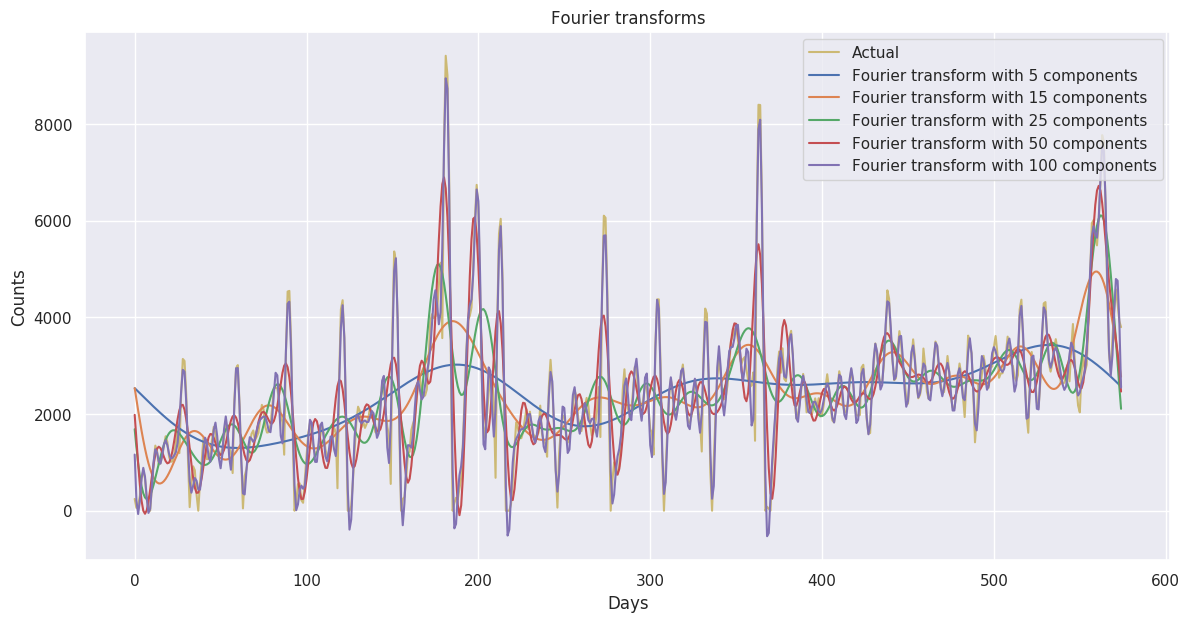

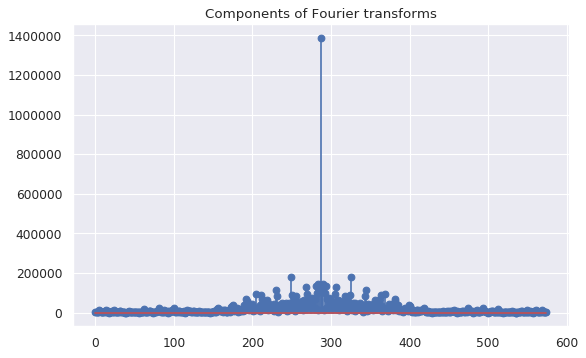

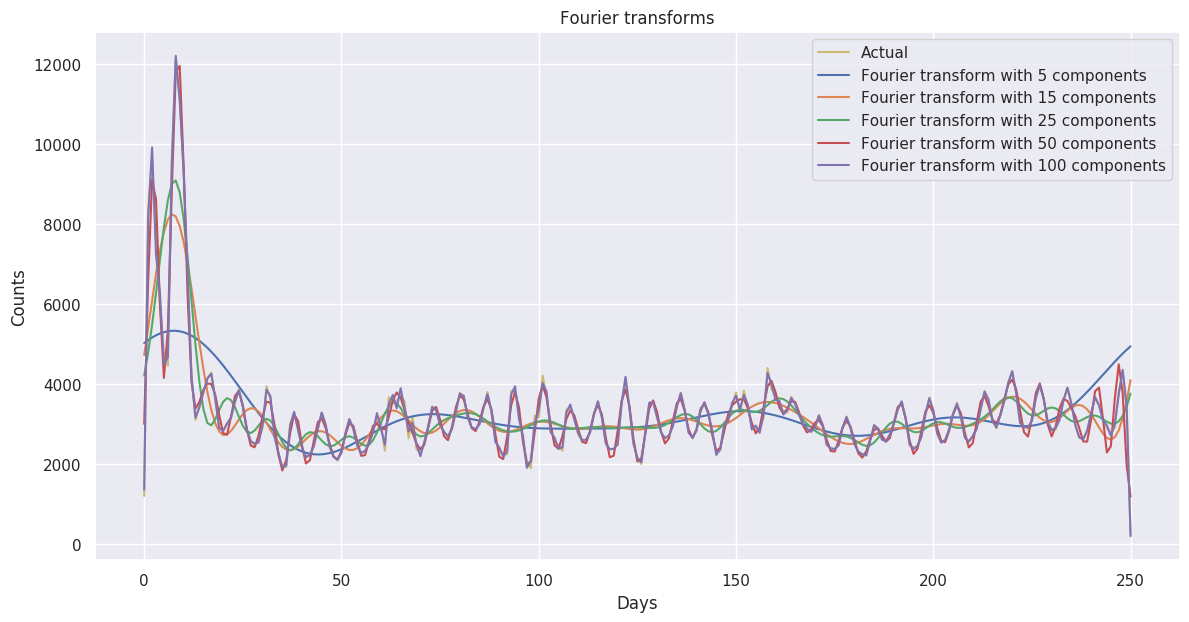

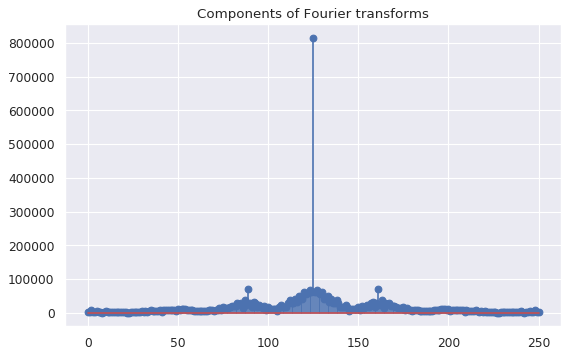

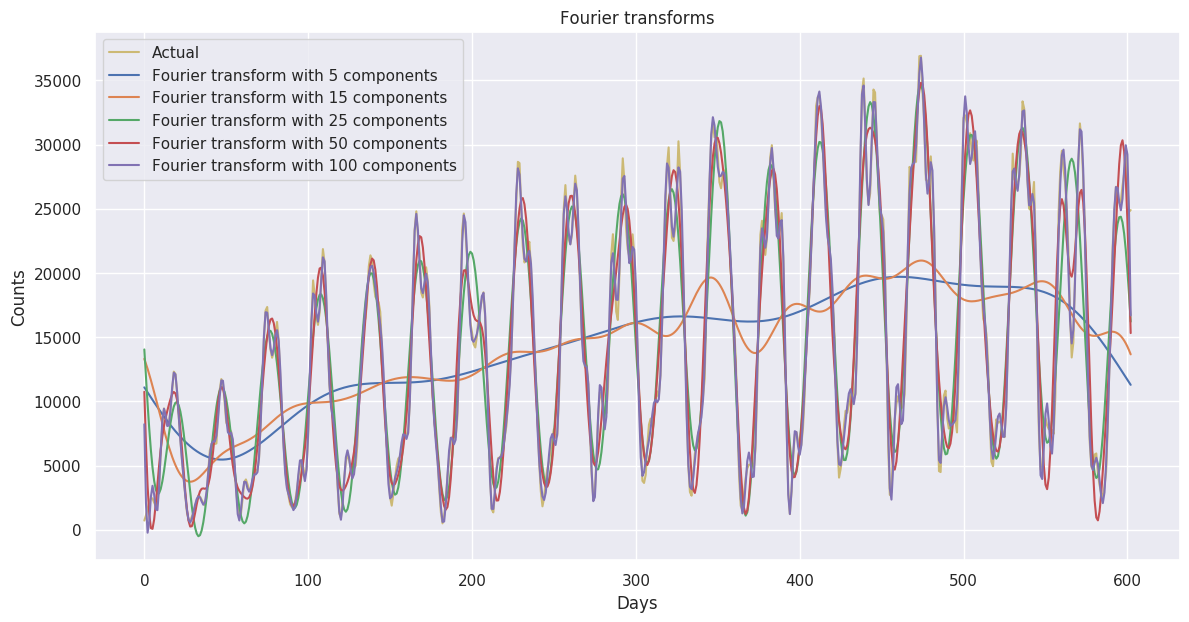

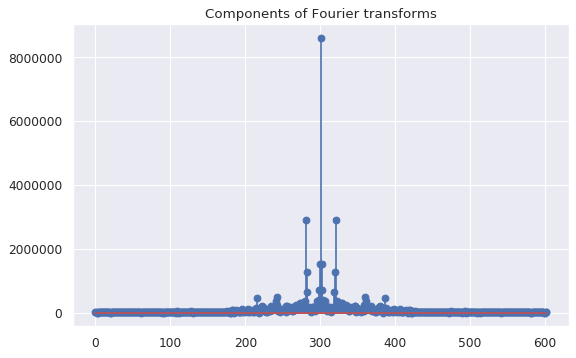

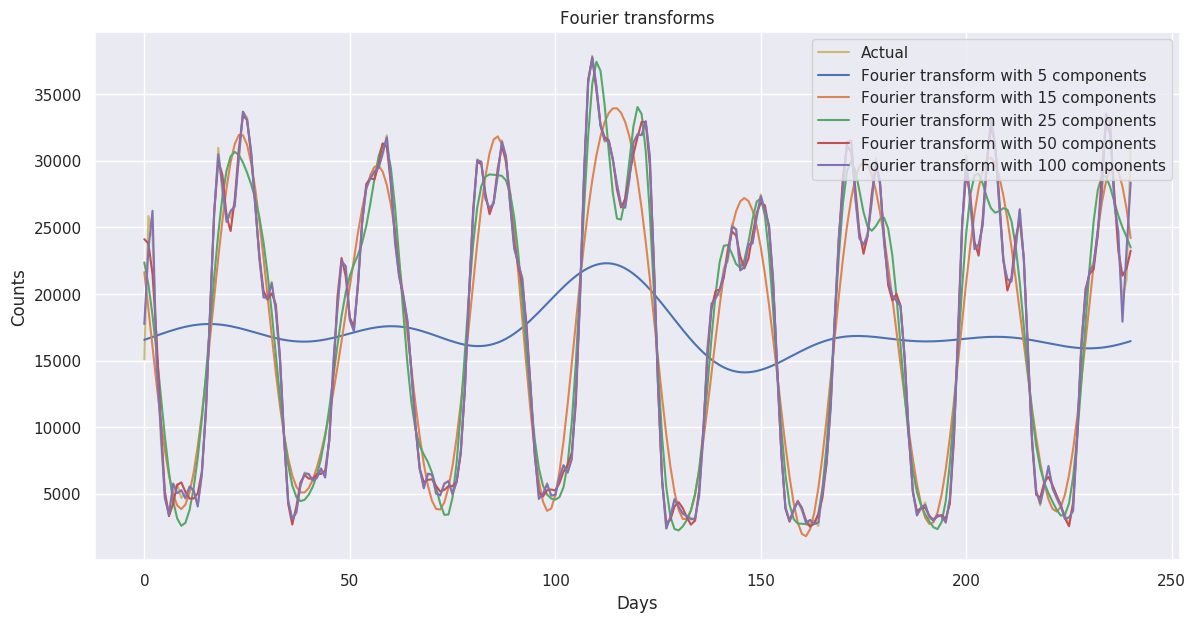

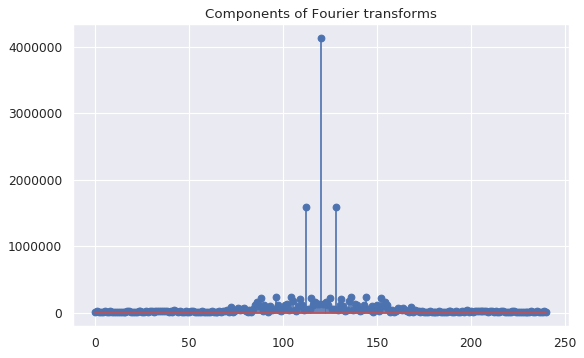

In [322]:
# Fourier transform with 50 components

def get_fourier_vars(dat):
    fft_list1=fourier_components(dat)
    fourier_order=100
    fft_list1_m10= np.copy(fft_list1)
    fft_list1_m10[fourier_order:-fourier_order]=0
    fvals = np.fft.ifft(fft_list1_m10)
    dat['f_absolute'] = pd.Series(fvals).apply(lambda x: np.abs(x)).values
    dat['f_angle'] = pd.Series(fvals).apply(lambda x: np.angle(x)).values
    return dat

train1=get_fourier_vars(train1)
val1=get_fourier_vars(val1) 

train2=get_fourier_vars(train2)
val2=get_fourier_vars(val2)    

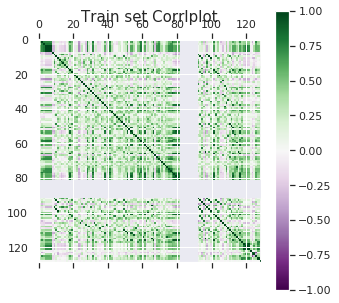

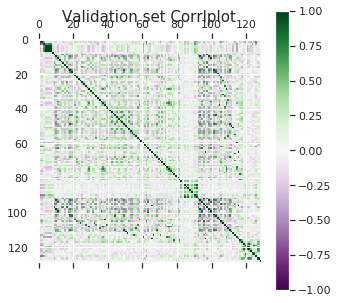

In [323]:
# Segment 1

#Corrlplot
plt.matshow(train1.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Train set Corrlplot', size=15)
plt.colorbar()
plt.show()

plt.matshow(val1.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Validation set Corrlplot', size=15)
plt.colorbar()
plt.show()

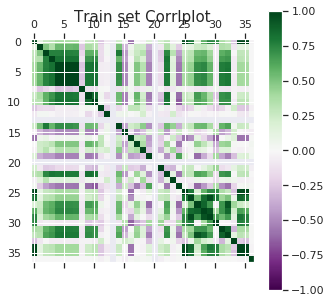

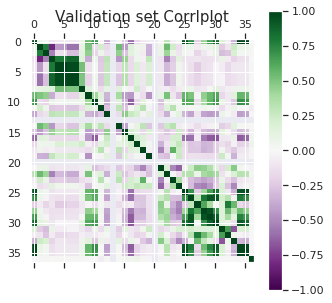

In [324]:
# Segment 2

plt.matshow(train2.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Train set Corrlplot', size=15)
plt.colorbar()
plt.show()

plt.matshow(val2.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Validation set Corrlplot', size=15)
plt.colorbar()
plt.show()

In [325]:
# Fitting ARIMA

from statsmodels.tsa.arima_model import ARIMA

series = train1['y']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  574
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4515.958
Method:                       css-mle   S.D. of innovations            631.354
Date:                Sat, 01 Feb 2020   AIC                           9045.916
Time:                        12:33:45   BIC                           9076.384
Sample:                    04-02-2017   HQIC                          9057.800
                         - 10-27-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3756     23.001      0.277      0.782     -38.706      51.457
ar.L1.D.y      0.3925      0.042      9.418      0.000       0.311       0.474
ar.L2.D.y     -0.1706      0.044     -3.918      0.0

In [326]:
#Check Stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(tdf,timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(52).mean()
    rolstd = timeseries.rolling(52).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(6, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    
    if dfoutput['p-value']<0.01:
        print("Process is stationary")
        tdf['ny']=tdf['y']
    else:
        print("Process is non-stationary, differencing for trend removal..")
        tdf['ny']=tdf['y']-tdf['y'].shift(1)
        tdf.fillna(0,inplace=True)
        test_stationarity(tdf,tdf['ny'])
    return tdf

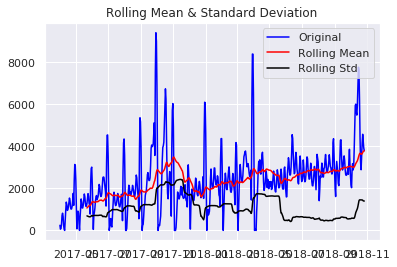

Results of Dickey-Fuller Test:
Test Statistic                  -3.224215
p-value                          0.018625
#Lags Used                      14.000000
Number of Observations Used    560.000000
Critical Value (1%)             -3.442081
Critical Value (5%)             -2.866715
Critical Value (10%)            -2.569526
dtype: float64
Process is non-stationary, differencing for trend removal..


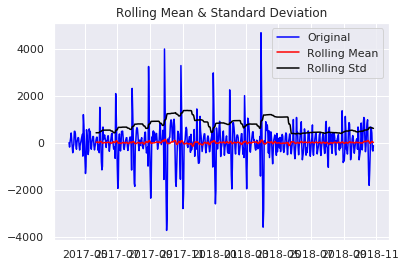

Results of Dickey-Fuller Test:
Test Statistic                -1.027703e+01
p-value                        3.866483e-18
#Lags Used                     1.500000e+01
Number of Observations Used    5.590000e+02
Critical Value (1%)           -3.442102e+00
Critical Value (5%)           -2.866724e+00
Critical Value (10%)          -2.569531e+00
dtype: float64
Process is stationary


In [327]:
_=test_stationarity(train1,train1.y)

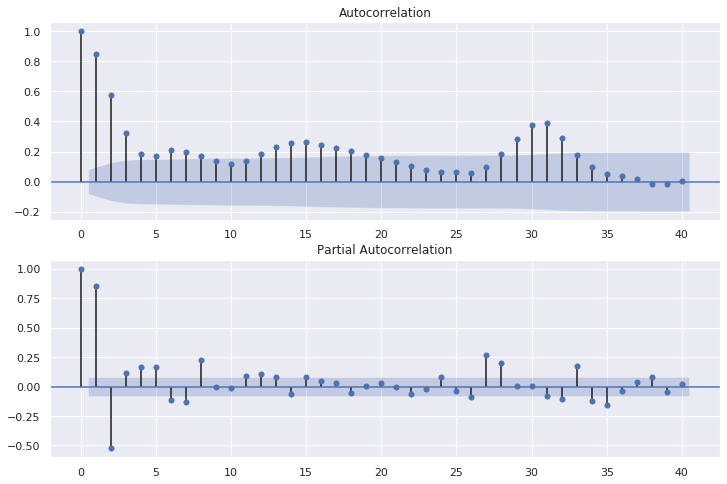

In [313]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train1['ny'].values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train1['ny'].values, lags=40, ax=ax2)
plt.show()

In [328]:
train1 = train1.drop('ny',1)

In [314]:
# Predicting within train set
from sklearn.metrics import mean_squared_error

X = train1.y.values
size = int(len(X) * 0.66)
tr, te = X[0:size], X[size:len(X)]
history = [x for x in tr]
predictions = list()
for t in range(len(te)):
    model = ARIMA(history, order=(3,1,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = te[t]
    history.append(obs)

In [315]:
error = mean_squared_error(te, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 128093.075


In [316]:
print("Test MAPE: {}%".format(np.mean(np.abs((te - predictions) / te)) * 100))

Test MAPE: 30.797123199563647%


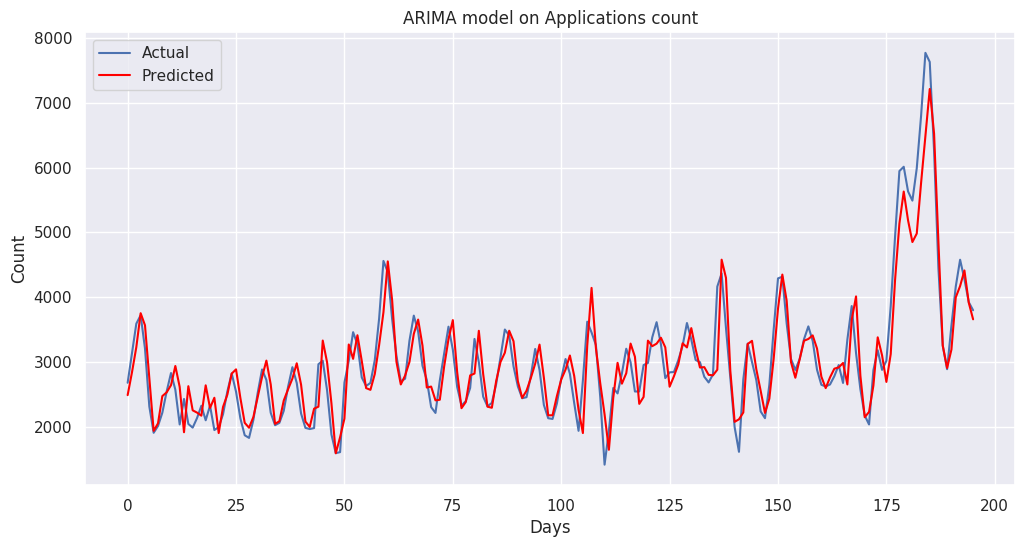

In [317]:
# Plot the predicted (from ARIMA) and real values

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(te, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('ARIMA model on Applications count')
plt.legend()
plt.show()

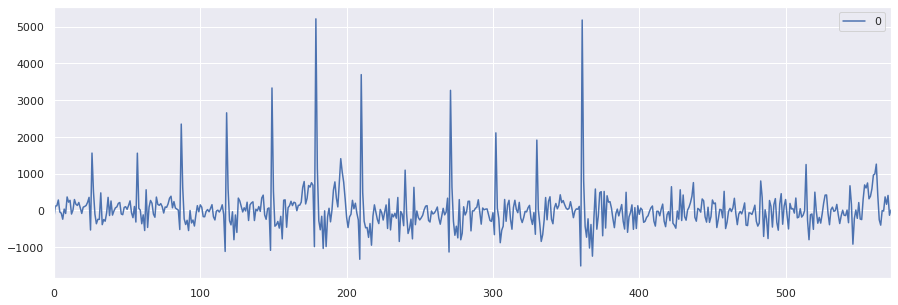

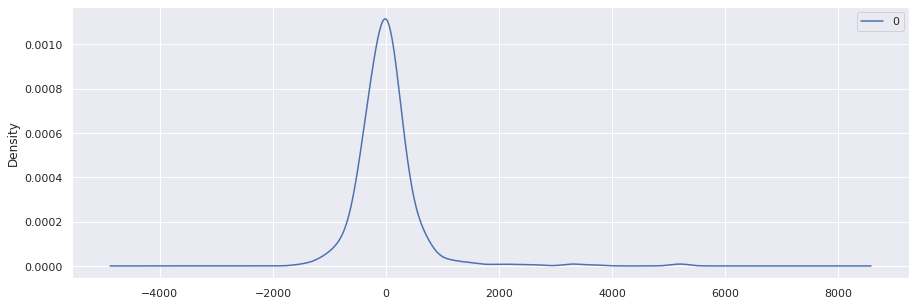

In [318]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
plt.show()

In [319]:
# Predicting for Validation set

from sklearn.metrics import mean_squared_error

tr, te = train1.y.values, val1.y.values
history = [x for x in tr]
predictions = list()
for t in range(len(te)):
    model = ARIMA(history, order=(3,1,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = te[t]
    history.append(obs)

error = mean_squared_error(te, predictions)
print('Test MSE: %.3f' % error)    
print("Test MAPE: {}%".format(np.mean(np.abs((te - predictions) / te)) * 100))

Test MSE: 555729.671
Test MAPE: 32.79039777099548%


## Final feature engineering

In [826]:
# Variables to be used in validation ensembling

arima_preds=predictions
proph_val_preds=pd.read_csv('./Data/proph_val_preds.csv')['proph_val_preds'].values

In [329]:
# Wrting intermediate features to disk

train1=train1[['ytrue']+[c for c in train1.columns if 'ytrue' not in c]]
val1=val1[['ytrue']+[c for c in val1.columns if 'ytrue' not in c]]

train1.to_csv('./Data/train1.csv',header=True,index=False)
val1.to_csv('./Data/val1.csv',header=True,index=False)

train2=train2[['ytrue']+[c for c in train2.columns if 'ytrue' not in c]]
val2=val2[['ytrue']+[c for c in val2.columns if 'ytrue' not in c]]

train2.to_csv('./Data/train2.csv',header=True,index=False)
val2.to_csv('./Data/val2.csv',header=True,index=False)

In [330]:
## XGBoost for variable importance

In [331]:
def get_xgboost_data(traindat,testdat):
    datatr = traindat.copy()
    datate = testdat.copy()
    y_train = datatr['ytrue']
    X_train = datatr.drop('ytrue',axis=1)
    
    X_test = datate.drop('ytrue',axis=1)
    y_test = datate['ytrue']
    
    return (X_train, y_train), (X_test, y_test)

## Below cells depend on the segment selected, choose between segment 1 and 2 when given the choice

In [238]:
# Segment 1

(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_xgboost_data(train1,val1)
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [332]:
# Segment 2

(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_xgboost_data(train2,val2)
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [333]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[12:34:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [334]:
eval_result = regressor.evals_result()

In [335]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

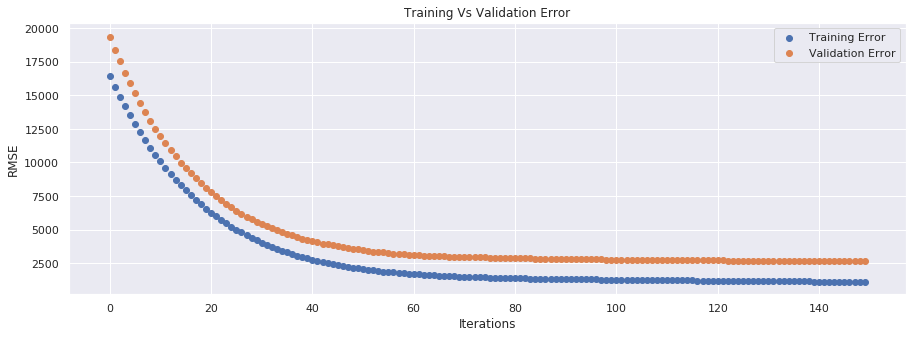

In [336]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

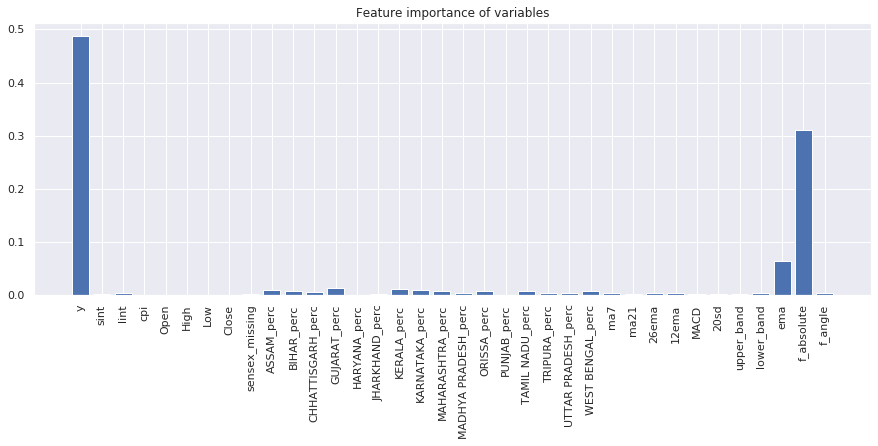

In [337]:
fig = plt.figure(figsize=(15,5))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Feature importance of variables')
plt.show()

In [338]:
fi_dict = dict(zip(xgbModel.feature_importances_,X_test_FI.columns))

In [339]:
# Top 10 features
impkeys=sorted(fi_dict.keys())[-10:]
for i in impkeys:
    print((i,fi_dict[i]))

(0.008047698, 'WEST BENGAL_perc')
(0.00817732, 'ORISSA_perc')
(0.008322033, 'TAMIL NADU_perc')
(0.009190997, 'KARNATAKA_perc')
(0.010160192, 'ASSAM_perc')
(0.011167422, 'KERALA_perc')
(0.012956805, 'GUJARAT_perc')
(0.06467879, 'ema')
(0.31023365, 'f_absolute')
(0.4874784, 'y')


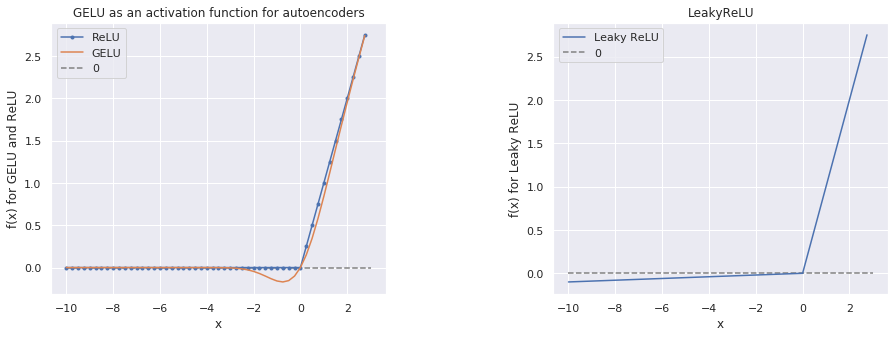

In [340]:
## Variational AutoEncoder for feature reduction

def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('LeakyReLU')
plt.legend()

plt.show()

In [248]:
# Segment 1 

from sklearn.preprocessing import MinMaxScaler
trvalues = train1.values.astype('float32') 
tevalues = val1.values.astype('float32') 

VAE_data = np.vstack((trvalues,tevalues))

scaler = MinMaxScaler(feature_range=(0, 1))
VAE_data = scaler.fit_transform(VAE_data)
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_scaled = scaler.fit_transform(tevalues)
# test_scaled = scaler.transform(tevalues)

num_training_days=575

In [341]:
# Segment 2

from sklearn.preprocessing import MinMaxScaler
trvalues = train2.values.astype('float32') 
tevalues = val2.values.astype('float32') 

VAE_data = np.vstack((trvalues,tevalues))

scaler = MinMaxScaler(feature_range=(0, 1))
VAE_data = scaler.fit_transform(VAE_data)
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_scaled = scaler.fit_transform(tevalues)
# test_scaled = scaler.transform(tevalues)

num_training_days=603

In [342]:
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,1:]}, \
                               label={'label': VAE_data[:num_training_days, 0]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,1:]}, \
                              label={'label': VAE_data[num_training_days:,0]}, batch_size = batch_size)

In [343]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [344]:
n_hidden=400 # neurons in each layer
n_latent=3
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 
model_prefix = 'vae_gluon2_{}d{}l{}h.params'.format(n_latent, n_layers, n_hidden)

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type='relu')

In [345]:
net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [346]:
print(net)

VAE(
  (encoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 6, linear)
  )
  (decoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 36, Activation(sigmoid))
  )
)


In [347]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

Epoch 0, Training loss 25.57, Validation loss 20.34
Epoch 15, Training loss 19.92, Validation loss 21.23
Epoch 30, Training loss 19.90, Validation loss 21.27
Epoch 45, Training loss 19.89, Validation loss 21.29
Epoch 60, Training loss 19.88, Validation loss 21.30
Epoch 75, Training loss 19.87, Validation loss 21.31
Epoch 90, Training loss 19.87, Validation loss 21.32
Epoch 105, Training loss 19.86, Validation loss 21.33
Epoch 120, Training loss 19.86, Validation loss 21.33
Epoch 135, Training loss 19.86, Validation loss 21.34
Training completed in 16 seconds.


In [348]:
net.save_parameters(model_prefix)

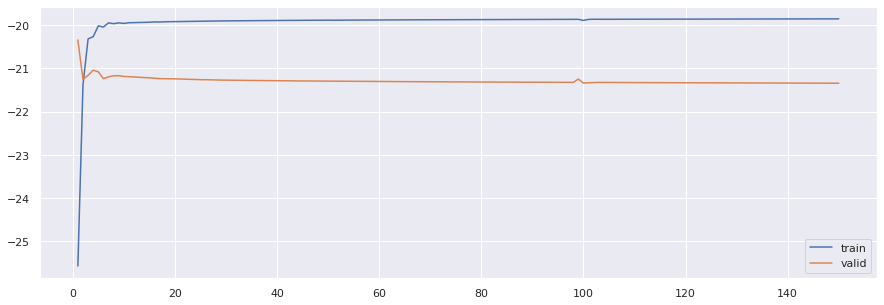

In [349]:
batch_x = np.linspace(1, n_epoch, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])


In [350]:
net2 = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size)
net2.load_parameters(model_prefix, ctx=model_ctx)

In [351]:
# Dont mind the error

train_iter.reset()
for i in range(50):    
    train_batch = train_iter.next()
    net2(train_batch.data[0].as_in_context(model_ctx))
    result = net2.output.asnumpy()
    original = train_batch.data[0].asnumpy()    
    if i==0:
        original1 = original
        result1=result
    else:
        original1 =np.vstack((original1,original))
        result1=np.vstack((result1,result))

print(original1.shape)
print(result1.shape)

StopIteration: 

In [352]:
# Dont mind the error

test_iter.reset()
for i in range(50):    
    test_batch = test_iter.next()
    net2(test_batch.data[0].as_in_context(model_ctx))
    result = net2.output.asnumpy()
    original = test_batch.data[0].asnumpy()    
    if i==0:
        originaltest1 = original
        resulttest1=result
    else:
        originaltest1 =np.vstack((originaltest1,original))
        resulttest1=np.vstack((resulttest1,result))

print(originaltest1.shape)
print(resulttest1.shape)

StopIteration: 

In [353]:
vae_added_df = result1

In [354]:
# We want the PCA to create the new components to explain 80% of the variance
pca = PCA(n_components=.9)

In [355]:
x_pca = StandardScaler().fit_transform(vae_added_df)

In [356]:
principalComponents = pca.fit_transform(x_pca)

In [357]:
pca.n_components_

2

In [358]:
x_pca = StandardScaler().fit_transform(resulttest1)
principalComponentstest = pca.fit_transform(x_pca)
pca.n_components_

2

In [569]:
# Segment 1

train1w = pd.concat([train1,pd.DataFrame(principalComponents[:train1.shape[0]],columns=['vae_feat'+str(i) for i in range(principalComponents.shape[1])],index=train1.index)],axis=1) # Adding vae pc as feature to train data
val1w = pd.concat([val1,pd.DataFrame(principalComponentstest[:val1.shape[0]],columns=['vae_feat'+str(i) for i in range(principalComponentstest.shape[1])],index=val1.index)],axis=1) # Adding vae pc as feature to test data

train1w=train1w[['ytrue']+[c for c in train1w.columns if 'ytrue' not in c]]
val1w=val1w[['ytrue']+[c for c in val1w.columns if 'ytrue' not in c]]

train1w.to_csv('./Data/train1.csv',header=True,index=False)
val1w.to_csv('./Data/val1.csv',header=True,index=False)

train1w.head()

In [360]:
# Segment 2

#train2['vae_feat'] = principalComponents[:train2.shape[0]] 
#val2['vae_feat'] = principalComponentstest[:val2.shape[0]] 

train2w = pd.concat([train2,pd.DataFrame(principalComponents[:train2.shape[0]],columns=['vae_feat'+str(i) for i in range(principalComponents.shape[1])],index=train2.index)],axis=1) # Adding vae pc as feature to train data
val2w = pd.concat([val2,pd.DataFrame(principalComponentstest[:val2.shape[0]],columns=['vae_feat'+str(i) for i in range(principalComponentstest.shape[1])],index=val2.index)],axis=1) # Adding vae pc as feature to test data

train2w=train2w[['ytrue']+[c for c in train2w.columns if 'ytrue' not in c]]
val2w=val2w[['ytrue']+[c for c in val2w.columns if 'ytrue' not in c]]

train2w.to_csv('./Data/train2.csv',header=True,index=False)
val2w.to_csv('./Data/val2.csv',header=True,index=False)

train2w.head()

,ytrue,y,sint,lint,cpi,Open,High,Low,Close,sensex_missing,...,12ema,MACD,20sd,upper_band,lower_band,ema,f_absolute,f_angle,vae_feat0,vae_feat1
ds,,,,,,,,,,,,,,,,,,,,,
2017-04-01,897.0,719.333333,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,719.333333,0.000000,0.0,0.0,0.0,719.333333,8219.328625,-0.010955,-1.447847,0.171990
2017-04-02,605.0,1120.952381,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,936.876984,9.010684,0.0,0.0,0.0,1020.547619,2065.925210,-0.028035,-1.447910,0.171994
2017-04-03,2016.0,1640.452381,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,1211.482624,27.591064,0.0,0.0,0.0,1449.712454,231.142687,3.004409,-1.447881,0.172006
2017-04-04,2245.0,2141.000000,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,1504.894934,53.437679,0.0,0.0,0.0,1916.331548,665.467116,0.135365,-1.447883,0.172006
2017-04-05,2415.0,2459.047619,6.24,6.7925,1.858736,27211.403876,27323.040943,27103.475916,27197.746114,0.322581,...,1764.134808,79.013192,0.0,0.0,0.0,2279.637348,2553.999184,0.023105,-1.447882,0.172005
